In [20]:
#When calculating undelrying UNI held by depositing in each pool, I figured that a good heuristic would 
#simply be to take the total outstanding derivative tokens divided by UNI locked in each pool. This
#data pipeline can thus be automated for every token. However, the current limitation is that the 
#pool lists must be found by hand. So I could only select from the largest contract pools

#One also needs to take into account the sort of liquidity mining programs like big data protocol. Unfortunately,
# these new protocols often don't issue a synthethic version of the token when depositors stake UNI in their vaults, 
# so underlying UNI ownership is 
# difficult to track

#In this case, I simply removed BDP from the calculations with a remove() function

#For a more in-depth analysis, I propose that Nansen can be used to track depositors in a particular contract, at a monthly subscription cost to 1kx

UNI_pool_contract_list = {'cUNI': '0x35a18000230da775cac24873d00ff85bccded550',
                         'UNI-WETH': '0xd3d2e2692501a5c9ca623199d38826e513033a17',
                          'UNI_BDP': '0x0De845955E2bF089012F682fE9bC81dD5f11B372'
                         }
#For Sushi, will remove the MasterChef Contract ownership as well, since those are tokens that are 
#distributed VIA A GOVERNANCE PROCESS. This means it should not have a net effect on token inequality, theoretically.
#Same principle applies to Balancer DAO contract, whose funds will be removed from calculations

SUSHI_pool_contract_list = {'xSUSHI':'0x8798249c2E607446EfB7Ad49eC89dD1865Ff4272',
                            'SUSHI-ETH':'0x795065dCc9f64b5614C407a6EFDC400DA6221FB0',
                            'crSUSHI': '0x338286C0BC081891A4Bda39C7667ae150bf5D206',
                            'MasterChef': '0xc2EdaD668740f1aA35E4D8f227fB8E17dcA888Cd',
                            'SUSHI_BDP': '0x0De845955E2bF089012F682fE9bC81dD5f11B372'
    
}

BAL_pool_contract_list = {'BAL-ETH':'0x59A19D8c652FA0284f44113D0ff9aBa70bd46fB4',
                          'BAL-WBTC':'0xbA20d4F41121b997a1EAcA6d938Ac40b67DAD226',
                          'crBAL': '0xcE4Fe9b4b8Ff61949DCfeB7e03bc9FAca59D2Eb3',
                          'BALDAO' : '0xb618F903ad1d00d6F7b92f5b0954DcdC056fC533'
}



In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:

def merge_farm_balances(pd1,pd2,contract_name, contract_list):
    #Add UNI ownership for UNI_WETH LP providers

    #Get total UNI/SUSHI/BAL amount in pool 
    net_tokens = pd1[pd1['HolderAddress'] == contract_list[contract_name].lower()].iloc[0]['Balance']
    print('Total tokens in pool', net_tokens)
    #Get total LP/farm shares 
    total_shares = pd2["Balance"].sum()
    print('Total LP shares', total_shares)
    #Calculate share of each LP/farm in pool, and thus how much UNI/SUSHI/BAL they own
    pd2["Balance_y"] = (pd2["Balance"]/total_shares)*net_tokens
    #Merge in 
    pd3 = pd.merge(pd2.drop(['Balance'],axis = 1),pd1,how="outer", on = "HolderAddress")
    #Data Cleanup
    pd3 = pd3.fillna(0)
    pd3["Balance"] = pd3["Balance"] + pd3["Balance_y"]
    return pd3.drop(["Balance_y"], axis = 1)
    
def remove_balances(pd, contract_name, contract_list):
    index = pd[pd['HolderAddress'] == contract_list[contract_name]].index
    pd_dropped = pd.drop(index)
    return pd_dropped
    
    

In [23]:
#HELPER FUNCTIONS
def gini_cal(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins[0:]:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

def plot(data):
    bins, result, gini_val = gini_cal(data)
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(bins, result, label="observed")
    plt.plot(bins, bins, '--', label="perfect eq.")
    plt.xlabel("fraction of population")
    plt.ylabel("fraction of wealth")
    plt.title("GINI: %.4f" %(gini_val))
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.hist(data, bins=20)

In [24]:
pd_UNI = pd.read_csv("./UNIholders.csv")
pd_LP_UNI_WETH = pd.read_csv("./LP_UNI_WETHholders.csv")
pd_cUNI = pd.read_csv("./cUNIholders.csv")
pd_UNI_1 = merge_farm_balances(pd_UNI,pd_LP_UNI_WETH,'UNI-WETH', UNI_pool_contract_list)
pd_UNI_2 = merge_farm_balances(pd_UNI_1,pd_cUNI,'cUNI', UNI_pool_contract_list)
pd_UNI_final = remove_balances(pd_UNI_2, 'UNI_BDP', UNI_pool_contract_list)

Total tokens in pool 2674052.7062676
Total LP shares 180495.76127164648
Total tokens in pool 5773382.76152564
Total LP shares 480324380.7043636


In [25]:
pd_SUSHI = pd.read_csv("./SUSHIholders.csv")
pd_LP_SUSHI_ETH = pd.read_csv("./LP_SUSHI_ETHholders.csv")
pd_xSUSHI = pd.read_csv('./xSUSHIholders.csv')
pd_crSUSHI = pd.read_csv('./crSUSHIholders.csv')

pd_SUSHI_1 = merge_farm_balances(pd_SUSHI,pd_LP_SUSHI_ETH,'SUSHI-ETH', SUSHI_pool_contract_list)
pd_SUSHI_2 = merge_farm_balances(pd_SUSHI_1,pd_xSUSHI,'xSUSHI', SUSHI_pool_contract_list)
pd_SUSHI_3 = merge_farm_balances(pd_SUSHI_2,pd_crSUSHI,'crSUSHI', SUSHI_pool_contract_list)
pd_SUSHI_4 = remove_balances(pd_SUSHI_3, 'SUSHI_BDP', SUSHI_pool_contract_list)
pd_SUSHI_final = remove_balances(pd_SUSHI_4, 'MasterChef', SUSHI_pool_contract_list)

Total tokens in pool 7935235.54690952
Total LP shares 702297.8198717133
Total tokens in pool 45760427.5918761
Total LP shares 40617223.87224835
Total tokens in pool 683358.24479513
Total LP shares 42561370.93507231


In [26]:
pd_BAL = pd.read_csv("./BALholders.csv")
pd_LP_BAL_ETH = pd.read_csv("./LP_BAL_ETHholders.csv")
pd_LP_BAL_WBTC = pd.read_csv('./LP_BAL_WBTCholders.csv')
pd_crBAL = pd.read_csv('./crBALholders.csv')

pd_BAL_1 = merge_farm_balances(pd_BAL,pd_LP_BAL_ETH,'BAL-ETH', BAL_pool_contract_list)
pd_BAL_2 = merge_farm_balances(pd_BAL_1,pd_LP_BAL_WBTC,'BAL-WBTC', BAL_pool_contract_list)
pd_BAL_3 = merge_farm_balances(pd_BAL_2,pd_crBAL,'crBAL', BAL_pool_contract_list)
pd_BAL_final = remove_balances(pd_BAL_3, 'BALDAO', BAL_pool_contract_list)

Total tokens in pool 3684770.96185693
Total LP shares 176887.61890924408
Total tokens in pool 68336.1274239536
Total LP shares 2990.661866459808
Total tokens in pool 38730.6617583722
Total LP shares 3445376.041134691


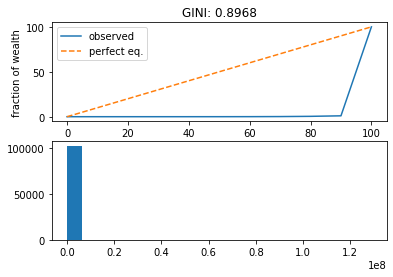

In [6]:
plot(pd_UNI_final["Balance"])

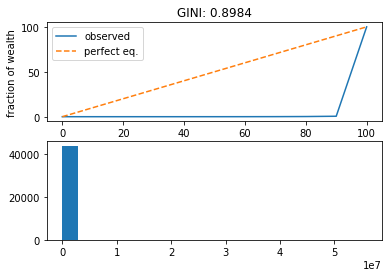

In [27]:
plot(pd_SUSHI_final["Balance"])

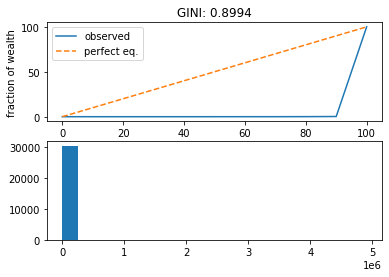

In [28]:
plot(pd_BAL_final["Balance"])